In [53]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
from torch import nn
plt.rcParams['figure.figsize'] = [5,3]
torch.__version__  # cuda 11.7

'1.13.1+cu117'

In [54]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
device

'cuda'

### Create Regression Dataset

In [55]:
weight = 0.7
bias = 0.3

np.random.seed(42)
torch.cuda.manual_seed(42)

X = torch.rand(100).unsqueeze(dim = 1)

# true relationship
y = X*weight + bias + np.random.normal(scale=0.01,size = X.shape[0]).reshape(-1,1)

X.shape, y.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

### Split into train and test data

In [56]:
train_size = 0.8 # 80-20 split

np.random.seed(42)

indices = np.arange(X.shape[0])  # create and shuffle indices
np.random.shuffle(indices)

# divide train and test index
train_index, test_index =  indices[:int(len(indices)*0.8)] , indices[int(len(indices)*0.8):]

# slice X and y 
X_train, X_test = X[train_index], X[test_index]
y_train , y_test = y[train_index], y[test_index]

In [57]:
X_train.shape, y_train.shape

(torch.Size([80, 1]), torch.Size([80, 1]))

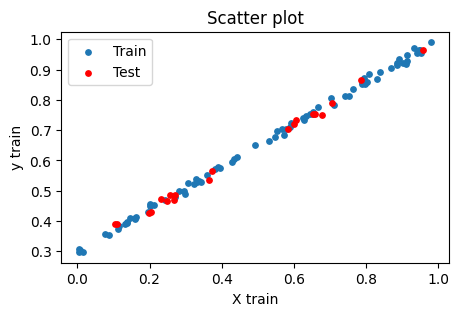

In [58]:
plt.scatter(X_train, y_train, label = 'Train', s= 15)
plt.scatter(X_test, y_test, c='r', label = 'Test', s= 15)
plt.xlabel('X train')
plt.ylabel('y train')
plt.title('Scatter plot')
plt.legend()
plt.show()

### Define model

In [59]:
# define model 
class LinearRegressionV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_model = nn.Linear(in_features=1, out_features=1, device=device)
    def forward(self, X: torch.Tensor):
        return self.linear_model(X)

In [60]:
torch.manual_seed(42)
model_0 = LinearRegressionV2()

In [61]:
model_0.state_dict()

OrderedDict([('linear_model.weight', tensor([[0.2259]], device='cuda:0')),
             ('linear_model.bias', tensor([0.9754], device='cuda:0'))])

### Define Loss function and optimizer

In [62]:
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)
loss_fn = nn.L1Loss()

### Train and Test loop

In [63]:

train_loss = []
test_loss = []
epochs = 400

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
for epoch in range(epochs):
    
    model_0.train()
    
    pred = model_0(X_train)
    
    loss = loss_fn(y_train, pred)
    
    train_loss.append(loss.item())
    optimizer.zero_grad()

    loss.backward()
    
    optimizer.step()
    
    model_0.eval() 
    with torch.inference_mode():
        pred_te = model_0(X_test)
        loss_te = loss_fn(y_test, pred_te)
        test_loss.append(loss_te.item())
    
        
    if epoch%50 ==0:
        print(epoch , loss)
    

0 tensor(0.4331, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
50 tensor(0.1553, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
100 tensor(0.1279, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
150 tensor(0.1020, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
200 tensor(0.0762, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
250 tensor(0.0504, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
300 tensor(0.0252, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
350 tensor(0.0073, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


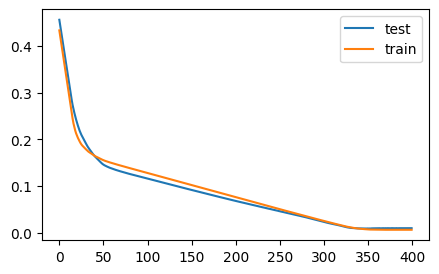

In [64]:
plt.plot(list(range(epochs)), test_loss, label = 'test')
plt.plot(list(range(epochs)), train_loss, label = 'train')
plt.legend()
plt.show()

### Tuned weights

In [65]:
model_0.state_dict()

OrderedDict([('linear_model.weight', tensor([[0.6991]], device='cuda:0')),
             ('linear_model.bias', tensor([0.3004], device='cuda:0'))])

In [66]:
### Prediction

In [67]:
model_0.eval()
with torch.inference_mode():
    t_pred = model_0(X_test.to(device))

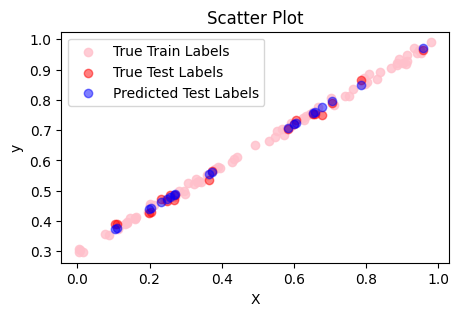

In [68]:
plt.scatter(X_train.cpu(), y_train.cpu(), alpha = 0.8,c ='pink', label='True Train Labels')
plt.scatter(X_test.cpu(), y_test.cpu(), alpha = 0.5,c ='r', label='True Test Labels')
plt.scatter(X_test.cpu(), t_pred.detach().cpu(),c='b', alpha = 0.5, label = 'Predicted Test Labels')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('Scatter Plot')
plt.show()

In [69]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models\model_0.pth


In [70]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionV2()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [71]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [72]:
loaded_model_preds == t_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')